In [6]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.ndimage.measurements import center_of_mass

In [7]:
"""
Extract images from npy files
"""
train_x = np.load('train_images.npy', encoding='latin1')
train_x = np.array([arr[1] for arr in train_x], np.uint8)
train_y = np.array(pd.read_csv('train_labels.csv', usecols=['Category']))

test_x = np.load('test_images.npy', encoding='latin1')
test_x = np.array([arr[1] for arr in test_x], np.uint8)
test_y = np.array(pd.read_csv('test_labels.csv', usecols=['Category']) 

In [56]:
"""
Finding contours for the
given greyscale image

@param
    :type np.array img_gray - greyscale version of the image

@return
    :rtype np.array - the image
    :rtype np.array - contours found for the image

"""
def find_contours(img_gray):
    ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
    thresh = thresh.astype('uint8')
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return image, contours

In [64]:
"""
Cleaning out the noise from the
image based on the contours found
using find_contours(img_gray)

@param
    :type int idx - idx of image from the dataset of images
    
@return
    :rtpe np.array - cleaned version of the image
"""

def clean_noise_by_contours(idx):
    img_gray = train_x[idx].reshape(100, 100)
    image, contours = find_contours(img_gray)
    num_contour = len(contours)
    
    max_area = 0
    max_area_idx = 0
    for i in range(0, num_contour):
        contour = contours[i]
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_area_idx = i
    
    for i in range(0, num_contour):
        if i != max_area_idx:
            cv2.drawContours(image, contours, i, -1, 3)
            
    plt.imshow(image)
    return image

In [ ]:
"""
Crop the cleaned image to
return just the drawing
in a smaller square

@param
    :type np.array cleaned_img - cleaned image
    
@return
    :rtype np.array - cropped version of the cleaned image
"""

def cropImage(cleaned_img):
    sq_side_length = 30
    sq_half_side = sq_side_length/2
    center_h, center_w = center_of_mass(cleaned_img)
    top_h = int(center_h - sq_half_side)
    bottom_h = int(center_h + sq_half_side)
    left_w = int(center_w - sq_half_side)
    right_w = int(center_w + sq_half_side)
    cropped_img = cleaned_img[top_h:bottom_h + 1, left_w:right_w + 1]
    plt.imshow(cropped_img)
#     return cropped_img

In [ ]:
"""
Rotates the given image 
by 'angle' degrees

@param
    :type np.array img - image to rotate
    :type int angle - angle in degrees to rotate by
    
@return
    :rtype np.array - original image rotated by 'angle' degrees
"""

def rotate(img, angle):
    rows, cols = img.shape

    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    dst = cv2.warpAffine(img, M, (cols,rows))
    plt.imshow(dst)
    return dst

['rollerskates']


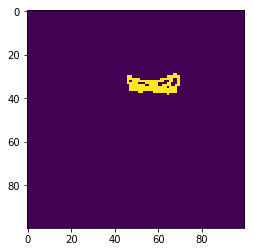

In [65]:
idx = random.randint(0, 9999)
cleaned_img = clean_noise_by_contours(idx)
print(train_y_list[idx])

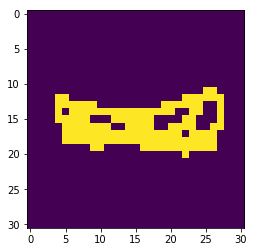

In [73]:
cropImage(cleaned_img)

In [ ]:
rotate(clean_img, 90)

In [ ]:
class image:
    def __init__(self, raw):
        self.raw = raw
        # self.img is a cv2 array
        self.img = self.raw.reshape(100, 100)
        # grayscaled image
        self.grayscaled_img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        # resize grayscaled image
        self.gray = cv2.resize(self.grayscaled_img, (100, 100))
        # grayscaled image after max pooling
        self.resized_img = None
        
    def show(self, img):
        plt.imshow(img)

    def clean_noise(self):
        img = self.gray
        ret, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
        im2, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_NONE)
        self.show(im2)
        return contours
        
                
    # A technique to reduce the dimensions of an image by taking the maximum pixel value of a grid. 
    # This also helps reduce over-fitting and makes the model more generic. 
    def max_pooling(self, side_len):
        slice_x = 100/side_len
        slice_y = slice_x
        res = np.zeros((slice_x, slice_y))
        for i in range(0, slice_x):
            for j in range(0, slice_y):
                max = 0
                for p in range(i*side_len, (i+1)*side_len):
                    for q in range(j*side_len, (j+1)*side_len):
                        val = self.grayscaled_img[p][q]
                        if val>max: 
                            max = val
                res[i][j] = max
        self.resized_img = res
        return res